In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from IPython.display import clear_output
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

In [2]:
torch.__version__

'2.3.1+cu118'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
#define value
batch_size = 1
num_epochs = 150
latent_size = 512
regWeight = 5e8

In [5]:
PATH = 'D:/AnimeData/'

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),          
    #transforms.Normalize(mean=0.5, std=0.5)  
])

In [7]:
dataset = ImageFolder(root=PATH, transform=transform)

In [8]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last= True)

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input: 3 x 128 x 128
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),

            # output: 3 x 64 x 64
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            # output: 64 x 32 x 32

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            # output: 128 x 16 x 16

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            # output: 256 x 8 x 8

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01),
            # output: 512 x 4 x 4

            nn.Conv2d(in_channels=512, out_channels=768, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(768),
            nn.LeakyReLU(0.01),
            # output: 768 x 2 x 2

            nn.Flatten(),
            #output : 768*2*2
            nn.Linear(in_features=768*2*2,out_features=1),
                 
            nn.Sigmoid()
            # output: 1 x 1 x 1
        )

        

    def forward(self, x):
        return self.main(x)


In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(in_features=latent_size, out_features= 2048, bias=False),
            nn.LeakyReLU(0.01),
            nn.Unflatten(1, (2048, 1, 1)),  

            # output : 1024 x 1 x 1
            nn.ConvTranspose2d(in_channels=2048, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.01),
            # output : 768 x 2 x 2
            
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.01),
            #output : 512 x 4 x 4

            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.01),
            # output: 128 x 8 x 8
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.01),
            # output : 256 x 16 x 16

            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            # output : 128 x 32 x 32

            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            # output : 128 x 64 x 64

            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Sigmoid()
            # output: 3 x 128 x 128            
        )

    def forward(self, x):
        return self.main(x)


torch.Size([1, 3, 128, 128])
Min value: 0.037877392023801804 Max value: 0.972055196762085
(3, 128, 128)


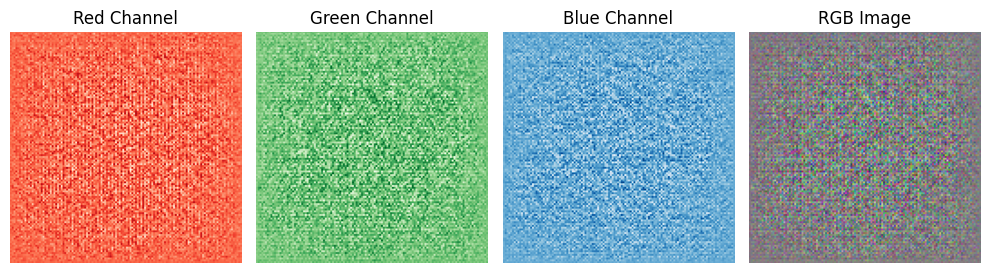

In [11]:
#test generator
random_tensor = torch.randn(1,latent_size)
generator_test = Generator()
result = generator_test(random_tensor)

print(result.shape)
print("Min value:", result.min().item(), "Max value:", result.max().item())

# Tách các kênh màu
red_channel = result.detach().numpy()[0, 0, :, :]  
green_channel = result.detach().numpy()[0, 1, :, :] 
blue_channel = result.detach().numpy()[0, 2, :, :] 

plt.figure(figsize=(10, 4))

# Red channel
plt.subplot(1, 4, 1)
plt.imshow(red_channel, cmap='Reds')
plt.title('Red Channel')
plt.axis('off')

# Green channel
plt.subplot(1, 4, 2)
plt.imshow(green_channel, cmap='Greens')
plt.title('Green Channel')
plt.axis('off')

# Blue channel
plt.subplot(1, 4, 3)
plt.imshow(blue_channel, cmap='Blues')
plt.title('Blue Channel')
plt.axis('off')
print(result[0].detach().numpy().shape)
# Stacked RGB image
plt.subplot(1, 4, 4)
plt.imshow(result[0].permute(1,2,0).detach().numpy())
plt.title('RGB Image')
plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
def make_image(epoch, generator, examples=25, dim=(5,5), figsize=(10,10)):
  noise= torch.randn(examples, latent_size).to(device)
  with torch.no_grad():
    generated_images = generator(noise).detach().cpu()
  plt.figure(figsize=figsize)
  plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


  for i in range(generated_images.shape[0]):
    # Ghép các kênh màu lại thành một ảnh RGB
    plt.subplot(5, 5, i + 1)
    image = generated_images[i].permute(1,2,0)
    plt.imshow(image,interpolation='nearest',cmap='gray_r')
    plt.axis('off')

  plt.tight_layout()
  path = 'D:\Adapt_rs'
  plt.savefig(os.path.join(path,'gan_generated_image %d.png' %epoch))
  plt.close('all')
  # plt.show()

In [13]:
#init the sub-network for GAN

generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   

In [14]:
criterion = nn.BCELoss()

In [15]:
optimizer_g = optim.Adam(generator.parameters(), lr=0.0006, betas=(0.5, 0.999))
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# G_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Generator_optimizer, mode='min', factor=0.5, patience=5)
# D_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(Discriminator_optimizer, mode='min', factor=0.5, patience=5)


In [16]:
# g_history = []
# d_history = []

# real_lb = 0.99
# fake_lb = 0

# for epoch in range(num_epochs):
#     #visualize the loss 
#     print('Epoch : ',f'[{epoch}/{num_epochs}] ')
#     plt.figure(figsize=(10,5))
#     plt.plot(range(1, len(g_history) + 1), g_history, 'b', label='Generator Loss')
#     plt.plot(range(1, len(g_history) + 1), d_history, 'r', label='Discriminator Loss')
#     plt.title('Generator and Discriminator Loss During Training')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()
#     plt.show()

#     avg_loss_d = 0 
#     avg_loss_g = 0
#     for i, data in enumerate(tqdm(dataloader)):
        
#         #train D with real data 
#         discriminator.zero_grad()
#         real_data = data[0].to(device)
#         label = torch.full((batch_size, ), real_lb,dtype=torch.float).to(device)
#         output = discriminator(real_data).view(-1)
#         loss_D_real = criterion(output,label)
#         loss_D_real.backward()
#         D_x = output.mean().item()

#         #train D with fake label 
#         noise = torch.randn(batch_size, latent_size).to(device)
#         fake_data = generator(noise)
#         label.fill_(fake_lb)
#         output = discriminator(fake_data.detach()).view(-1)
#         loss_D_fake = criterion(output, label)
#         loss_D_fake.backward()
#         D_G_z1 = output.mean().item()

#         loss_D = loss_D_real + loss_D_fake
#         avg_loss_d += loss_D

#         optimizer_d.step()

#         #train G 
#         generator.zero_grad()
#         noise = torch.randn(batch_size, latent_size).to(device)
#         fake_data = generator(noise)
#         output = discriminator(fake_data).view(-1)
#         label.fill_(real_lb)
#         loss_G = criterion(output, label)
#         avg_loss_g += loss_G
#         loss_G.backward()
#         D_G_z2 = output.mean().item()

#         optimizer_g.step()

#     avg_loss_d /= len(dataloader)
#     avg_loss_g /= len(dataloader)

#     d_history.append(avg_loss_d.detach().cpu().numpy())
#     g_history.append(avg_loss_g.detach().cpu().numpy())

#     if epoch != num_epochs:
#         clear_output()

#     print(  f'Loss_D: {avg_loss_d.item():.4f} Loss_G: {avg_loss_g.item():.4f} '
#             f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
    
#     if ( epoch % 5 == 0 ):
#         make_image(epoch, generator)
#         torch.save(generator.state_dict(), 'D:\G_md\epoch%d.pth' %epoch)
#         torch.save(discriminator.state_dict(), 'D:\D_md\epoch%d.pth' %epoch)
        
        


**Adaptation**

In [17]:
import torch.autograd as autograd


In [18]:
class EWC:
    """
    Class for performing Elastic Weight Consolidation
    Reference link:
        https://discuss.pytorch.org/t/implementation-of-elastic-weight-consolidation-fisher-information-matrix/9309/3 
    """

    def __init__(self, model_anchor):
        self._model_anchor = model_anchor
        self._params_anchor = {n: p for n, p in model_anchor.named_parameters()}


    def _calc_fisher(self, likelihood, nsample=1):
        grads = autograd.grad(likelihood, self._model_anchor.parameters())
        fs = [(g**2).sum()/nsample for g in grads ]

        param_names = [name for name, _ in self._model_anchor.named_parameters()]
        fs_dict = {n: f.item() for n, f in zip(param_names, fs)}

        return fs_dict
    

    def set_fisher(self, likelihood, nsample=1):
        self._fishers = self._calc_fisher(likelihood, nsample=nsample)


    def get_fisher(self): return self._fishers

    
    def calc_ewc(self, model, weight=5e8):
        params = {n: p for n, p in model.named_parameters()}

        ewc = 0
        for name in self._fishers:
            _ewc = self._fishers[name]*(params[name] - self._params_anchor[name])**2
            ewc += _ewc.sum()

        return weight*ewc


# def fisher(model, likelihood, nsample=1):
#     """
#     Funny ref link:
#     https://discuss.pytorch.org/t/implementation-of-elastic-weight-consolidation-fisher-information-matrix/9309/3 
#     """

#     grads = autograd.grad(likelihood, model.parameters())
#     fs = []
#     for g in grads:
#         fs.append((g**2).sum()/nsample) 

#     param_names = [name for name, _ in model.named_parameters()]
#     fs_dict = {n: f.item() for n, f in zip(param_names, fs)}

#     return fs_dict


def loss_adapt(l_adv, ewc, model, weight=5e8):
    l_ewc = ewc.calc_ewc(model, weight=weight)
    return l_adv + l_ewc

In [19]:
dataset = ImageFolder(root='D:\FaceTest', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, drop_last= True)

In [20]:
adapt_generator1 = Generator()
adapt_discriminator1 = Discriminator()

adapt_generator1.load_state_dict(torch.load('D:\G_md\epoch145.pth'))
adapt_discriminator1.load_state_dict(torch.load('D:\D_md\epoch145.pth'))

adapt_generator1.to(device)
adapt_discriminator1.to(device)

optimizer_g_ad1 = optim.Adam(adapt_generator1.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_d_ad1 = optim.Adam(adapt_discriminator1.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [21]:
zero_lamda_g_history = []
zero_lamda_d_history = []

real_lb = 0.99
fake_lb = 0

for epoch in range(num_epochs):
    #visualize the loss 
    print('Epoch : ',f'[{epoch}/{num_epochs}] ')
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(zero_lamda_g_history) + 1), zero_lamda_g_history, 'b', label='Generator Loss')
    plt.plot(range(1, len(zero_lamda_g_history) + 1), zero_lamda_d_history, 'r', label='Discriminator Loss')
    plt.title('Generator and Discriminator Loss During Adaptation with lamda=0')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    avg_loss_d = 0 
    avg_loss_g = 0
    for i, data in enumerate(tqdm(dataloader)):
        
        #train D with real data 
        adapt_discriminator1.zero_grad()
        real_data = data[0].to(device)
        label = torch.full((batch_size, ), real_lb,dtype=torch.float).to(device)
        output = adapt_discriminator1(real_data).view(-1)
        loss_D_real = criterion(output,label)       
        loss_D_real.backward()
        D_x = output.mean().item()

        #train D with fake label 
        noise = torch.randn(batch_size, latent_size).to(device)
        fake_data = adapt_generator1(noise)
        label.fill_(fake_lb)
        output = adapt_discriminator1(fake_data.detach()).view(-1)
        loss_D_fake = criterion(output, label)
        loss_D_fake.backward()
        D_G_z1 = output.mean().item()

        loss_D = loss_D_real + loss_D_fake
        avg_loss_d += loss_D

        optimizer_d_ad1.step()

        #train G 
        adapt_generator1.zero_grad()
        noise = torch.randn(batch_size, latent_size).to(device)
        fake_data = adapt_generator1(noise)
        output = adapt_discriminator1(fake_data).view(-1)
        label.fill_(real_lb)
        loss_G= criterion(output, label)
        avg_loss_g += loss_G
        loss_G.backward()
        D_G_z2 = output.mean().item()

        optimizer_g_ad1.step()

    avg_loss_d /= len(dataloader)
    avg_loss_g /= len(dataloader)

    zero_lamda_d_history.append(avg_loss_d.detach().cpu().numpy())
    zero_lamda_g_history.append(avg_loss_g.detach().cpu().numpy())

    if epoch != num_epochs:
        clear_output()

    print(  f'Loss_D: {avg_loss_d.item():.4f} Loss_G: {avg_loss_g.item():.4f} '
            f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
    
    
        
        


Loss_D: 0.0869 Loss_G: 5.1054 D(x): 0.9982 D(G(z)): 0.0130 / 0.0208


In [22]:
make_image(5,adapt_generator1)

In [23]:
adapt_generator2 = Generator()
adapt_discriminator2 = Discriminator()

adapt_generator2.load_state_dict(torch.load('D:\G_md\epoch145.pth'))
adapt_discriminator2.load_state_dict(torch.load('D:\D_md\epoch145.pth'))

adapt_generator2.to(device)
adapt_discriminator2.to(device)

optimizer_g_ad2 = optim.Adam(adapt_generator2.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_d_ad2 = optim.Adam(adapt_discriminator2.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [24]:
ewc_gen = EWC(adapt_generator2)

In [25]:
ad_g_history = []
ad_d_history = []

real_lb = 0.99
fake_lb = 0

for epoch in range(num_epochs):
    #visualize the loss 
    print('Epoch : ',f'[{epoch}/{num_epochs}] ')
    plt.figure(figsize=(10,5))
    plt.plot(range(1, len(ad_g_history) + 1), ad_g_history, 'b', label='Generator Loss')
    plt.plot(range(1, len(ad_g_history) + 1), ad_d_history, 'r', label='Discriminator Loss')
    plt.title('Generator and Discriminator Loss During Adaptation with lamda is fixed')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    avg_loss_d = 0 
    avg_loss_g = 0

    label = torch.full((batch_size, ), real_lb,dtype=torch.float).to(device)
    noise = torch.randn(batch_size, latent_size).to(device)
    fake_data = adapt_generator2(noise)
    output = adapt_discriminator2(fake_data).view(-1)
    label.fill_(real_lb)
    loss_G_adv = criterion(output, label)
    ewc_gen.set_fisher(loss_G_adv, nsample=batch_size)

    for i, data in enumerate(tqdm(dataloader)):
        
        #train D with real data 
        adapt_discriminator2.zero_grad()
        real_data = data[0].to(device)
        label = torch.full((batch_size, ), real_lb,dtype=torch.float).to(device)
        output = adapt_discriminator2(real_data).view(-1)
        loss_D_real = criterion(output,label)       
        loss_D_real.backward()
        D_x = output.mean().item()

        #train D with fake label 
        noise = torch.randn(batch_size, latent_size).to(device)
        fake_data = adapt_generator2(noise)
        label.fill_(fake_lb)
        output = adapt_discriminator2(fake_data.detach()).view(-1)
        loss_D_fake = criterion(output, label)
        loss_D_fake.backward()
        D_G_z1 = output.mean().item()

        loss_D = loss_D_real + loss_D_fake
        avg_loss_d += loss_D

        optimizer_d_ad2.step()

        #train G 
        adapt_generator2.zero_grad()
        noise = torch.randn(batch_size, latent_size).to(device)
        fake_data = adapt_generator2(noise)
        output = adapt_discriminator2(fake_data).view(-1)
        label.fill_(real_lb)
        loss_G_adv= criterion(output, label)
        loss_G_adapt = loss_adapt(loss_G_adv, ewc_gen, adapt_generator2,weight=regWeight)
        avg_loss_g += loss_G_adapt
        loss_G_adapt.backward()
        D_G_z2 = output.mean().item()

        optimizer_g_ad2.step()

    avg_loss_d /= len(dataloader)
    avg_loss_g /= len(dataloader)

    ad_d_history.append(avg_loss_d.detach().cpu().numpy())
    ad_g_history.append(avg_loss_g.detach().cpu().numpy())

    if epoch != num_epochs:
        clear_output()

    print(  f'Loss_D: {avg_loss_d.item():.4f} Loss_G: {avg_loss_g.item():.4f} '
            f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')
    
        
        


Loss_D: 0.2647 Loss_G: 9.1704 D(x): 0.9978 D(G(z)): 0.0013 / 0.0000


In [ ]:
make_image(1,adapt_generator2)

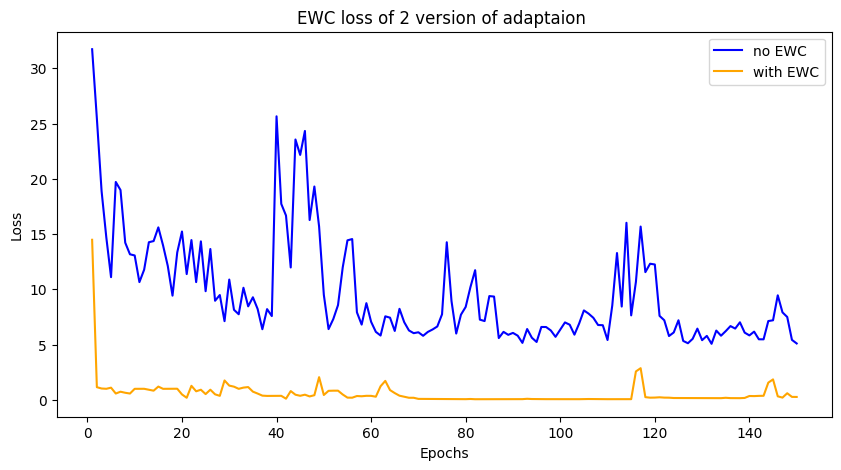

In [26]:
plt.figure(figsize=(10,5))
plt.plot(range(1, len(zero_lamda_g_history) + 1), zero_lamda_g_history, 'b', label='no EWC')
plt.plot(range(1, len(ad_g_history) + 1), ad_d_history, 'orange', label='with EWC')
plt.title('EWC loss of 2 version of adaptaion ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()